<h1>1. The NBA Career Prediction</h1>

<p>This .ipynb is designed to train a random forest using the provided file 2022_train.csv to predict if a NBA rookie player will last at least 5 years in the league based on its stats. We are currently using the default random forest settings with unconstrained depth and 200 trees. </p> 



In [190]:
"""
The NBA Career Prediction - assignment 1
Team member: Olivia Dewi, Federico Gonzales, Tim Wang
"""
import csv
import numpy as np
import pandas as pd
import os
import joblib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from IPython.display import display, HTML
from math import log
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import warnings
warnings.filterwarnings("ignore")

The scikit-learn version is 0.23.2.


<h1>2. We are provided with three sets of datasets. The train and test data sets, and a sample submission </h1>


In [191]:
#Let's grab the training data and test data provided
trainingdata =  pd.read_csv("2022_train.csv")
testdata = pd.read_csv("2022_test.csv")

In [193]:
#And investigate the columns in the training data
trainingdata.columns

Index(['Id', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'TARGET_5Yrs'],
      dtype='object')

<h1>Explanations on the data fields:</h1>

<p>Id - Player Identifier</p>
<p>GP - Games Played</p>
<p>MIN - Minutes Played</p>
<p>PTS - Points Per Game</p>
<p>FGM - Field Goals Made</p>
<p>FGA - Field Goals Attempts</p>
<p>FG% - Field Goals Percent</p>
<p>3P Made - 3-Points Made</p>
<p>3PA - 3-Points Attempts</p>
<p>3P% - 3-Points Percent</p>
<p>FTM - Free Throw Made</p>
<p>FTA - Free Throw Attempts</p>
<p>FT% - Free Throw Percent</p>
<p>OREB - Offensive Rebounds</p>
<p>DREB - Defensive Rebounds</p>
<p>REB - Rebounds</p>
<p>AST - Assists</p>
<p>STL - Steals</p>
<p>BLK - Blocks</p>
<p>TOV - Turnovers</p>
<p>TARGET_5Yrs - Outcome: 1 if career length >= 5 years, 0 otherwise</p>

<h1> 3. Let's explore the training data </h1>

In [194]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8000 non-null   int64  
 1   GP           8000 non-null   int64  
 2   MIN          8000 non-null   float64
 3   PTS          8000 non-null   float64
 4   FGM          8000 non-null   float64
 5   FGA          8000 non-null   float64
 6   FG%          8000 non-null   float64
 7   3P Made      8000 non-null   float64
 8   3PA          8000 non-null   float64
 9   3P%          8000 non-null   float64
 10  FTM          8000 non-null   float64
 11  FTA          8000 non-null   float64
 12  FT%          8000 non-null   float64
 13  OREB         8000 non-null   float64
 14  DREB         8000 non-null   float64
 15  REB          8000 non-null   float64
 16  AST          8000 non-null   float64
 17  STL          8000 non-null   float64
 18  BLK          8000 non-null   float64
 19  TOV   

In [195]:
trainingdata.describe()
#It is interesting to see that the Target_5Yrs column is extremely high, and majority of the dataset has a value of 1

,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,7798.50000,62.777875,18.576663,7.267087,2.807037,6.231213,44.608900,0.264525,0.816563,19.583700,...,1.947787,71.365825,1.077838,2.168500,3.245300,1.624513,0.648688,0.245212,1.257762,0.833625
std,2309.54541,17.118774,8.935263,4.318732,1.693373,3.584559,6.155453,0.384093,1.060964,16.003155,...,1.252352,10.430447,0.785670,1.392224,2.085154,1.355986,0.407626,0.821037,0.723270,0.372440
min,3799.00000,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,...,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000,0.000000
25%,5798.75000,51.000000,12.000000,4.100000,1.600000,3.600000,40.400000,0.000000,0.100000,8.400000,...,1.000000,65.000000,0.500000,1.100000,1.700000,0.700000,0.300000,0.100000,0.700000,1.000000
50%,7798.50000,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,...,1.700000,71.400000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000,1.000000
75%,9798.25000,74.000000,23.500000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.600000,...,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000,1.000000
max,11798.00000,123.000000,73.800000,34.200000,13.100000,28.900000,67.200000,1.700000,4.700000,82.100000,...,11.100000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,18.900000,5.300000,1.000000


Text(0.5, 1.0, 'Triangle Correlation Heatmap')

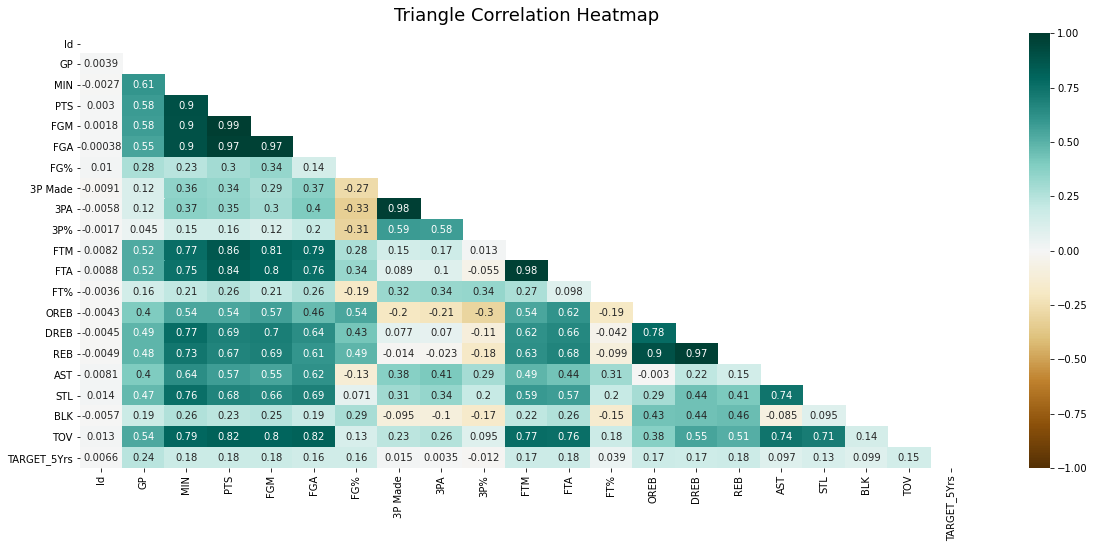

In [196]:
#Let's plot this on Seaborn to see the correlation between data
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(trainingdata.corr(), dtype=np.bool))
heatmap = sns.heatmap(trainingdata.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

<h1> 4. Let's separate the training data into the majority data set with TARGET_5Yrs =1, and the rest as minority class to oversample </h1>

In [197]:
majority_class_df = trainingdata[trainingdata['TARGET_5Yrs']==1]
minority_class_df = trainingdata[trainingdata['TARGET_5Yrs']==0]

In [198]:
majority_class_df.shape

(6669, 21)

In [199]:
minority_class_df.shape

(1331, 21)

In [206]:
#Applying random oversampling to triple the size of the minority class (to experiment and fine tune the model better later)
new_minority_class=resample(minority_class_df, replace=True, n_samples=3993, random_state=123)
new_minority_class_df= pd.DataFrame(new_minority_class)

In [201]:
#Check if this is now the right shape
new_minority_class_df.shape

(3993, 21)

In [202]:
majority_class_df.shape

(6669, 21)

In [207]:
#Combine the new oversampled data to the dataset
new_trainingdata = pd.concat([new_minority_class_df, majority_class_df], axis=0)

In [209]:
#Check the shape of the new training data
new_trainingdata.describe

<bound method NDFrame.describe of          Id   GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  ...  FTA  \
6640  10439  101  22.3  10.8  4.4  9.2  49.0      0.0  0.1  16.3  ...  3.5   
6154   9953   27   9.0   3.2  1.2  3.7  32.6      0.5  1.4  28.5  ...  0.5   
642    4441   72  15.3   4.8  1.9  4.2  45.7     -0.1 -0.2  21.6  ...  1.4   
6851  10650   53  12.3   2.8  0.9  2.7  31.7      0.1  0.9   9.7  ...  1.3   
7465  11264   45  10.8   3.0  1.3  3.1  42.5      0.4  1.2  18.7  ...  0.4   
...     ...  ...   ...   ...  ...  ...   ...      ...  ...   ...  ...  ...   
7995  11794   32   9.2   1.8  0.7  1.8  40.3     -0.1 -0.2  23.1  ...  0.6   
7996  11795   54   6.0   1.8  0.7  1.4  48.7      0.1  0.1   3.1  ...  0.4   
7997  11796   85  28.2  10.7  4.0  9.0  45.1      0.2  0.6  23.6  ...  3.9   
7998  11797   39   7.7   2.5  1.0  2.3  40.1     -0.3 -0.5  13.3  ...  0.7   
7999  11798   49  19.2   4.8  1.7  5.1  32.6      0.7  2.4  41.3  ...  1.3   

       FT%  OREB  DREB  REB  

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

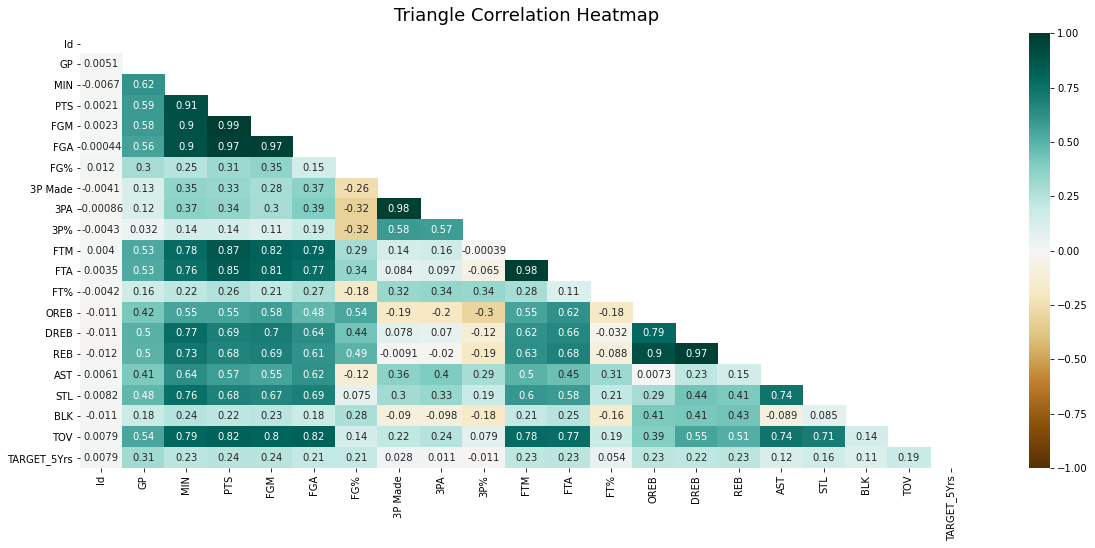

In [210]:
#Let's plot this on Seaborn to see the correlation between data in the new training set
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(new_trainingdata.corr(), dtype=np.bool))
heatmap = sns.heatmap(new_trainingdata.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

In [213]:
#Id is removed from the input columns
#PTS/MIN/FGA/FGM have very high correlation. I have kept FGA and removed the other three.
input_columns = [#'FGM', 'MIN', 'PTS','Id'
            '3P Made', 'FTM', 'STL', 'PTS','OREB', 'FTA', 'FGA', 'TOV', 'DREB', 'REB',
            'BLK', 'AST', '3PA', 'FT%', '3P%', 'FG%', 'GP']


In [214]:
X = new_trainingdata[input_columns]
y = new_trainingdata['TARGET_5Yrs']

In [216]:
#Experiment #1 - Random Forest Regressor
regressor = RandomForestRegressor(random_state=0, n_estimators=200)
regressor.fit(X, y) 

RandomForestRegressor(n_estimators=200, random_state=0)

['model.joblib']

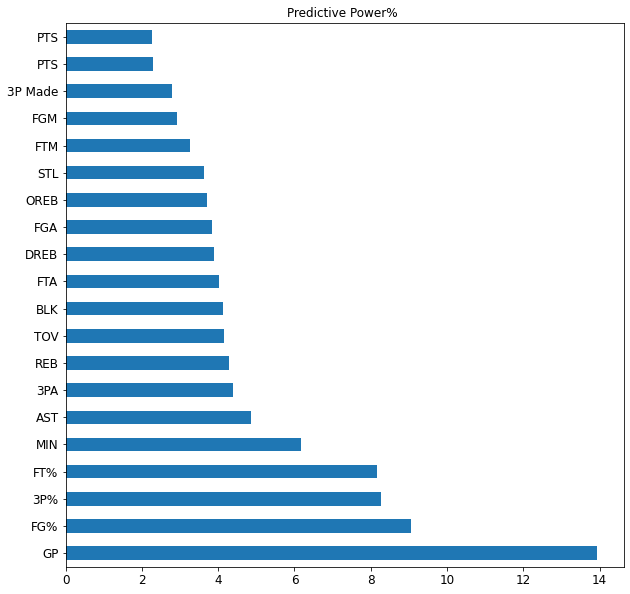

In [217]:
#Plotting the feature importance in the model to finetune it in the future
feature_imp = pd.Series(np.round(100 * regressor.feature_importances_,2), index = X.columns)
plt.figure(figsize=(10,10))
feature_imp.nlargest(30).plot(kind='barh', title='Predictive Power% ',fontsize=12)                        
plt.savefig('features.png', bbox_inches='tight')
joblibpath = 'model.joblib'
joblib.dump(regressor, joblibpath, compress=3)

In [ ]:
X=testdata[input_columns]
y_hat = regressor.predict(X)
y_hat_df = pd.DataFrame(y_hat)
y_hat_df.to_csv("prediction.csv")